<a href="https://colab.research.google.com/github/belacartaxo/computer-vision-masterclass/blob/master/02-face-recognition/practical_content.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face recognition

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Reading a compressed file
import zipfile
path = '/content/drive/MyDrive/Programação/ComputerVisionMasterclass/Datasets/yalefaces.zip'
zip_object = zipfile.ZipFile(file=path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [6]:
from PIL import Image
import cv2
import numpy as np

In [7]:
from matplotlib import pyplot as plt

def show_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

## Preprocessing the images

In [14]:
import os
def get_image_data():
    paths = [os.path.join('/content/yalefaces/train', f) for f in os.listdir('/content/yalefaces/train')]
    faces = []
    ids = []

    for path in paths:
        image = Image.open(path).convert('L') # L - single channel image (grayscale)
        image_np = np.array(image, 'uint8')
        id = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
        ids.append(id)
        faces.append(image_np)
    return np.array(ids), faces


## Training the LBPH classifier

In [15]:
'''
if we look at the shape we can see  all the images have the same size, and if they don't have we need to resize it
'''
ids, faces = get_image_data()

In [20]:
#By dafault each one of the images will have 64 histograms, because the image will me divided in 8 rows and 8 cols
lbph_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

## Recognizing faces

In [21]:
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('/content/lbph_classifier.yml')

In [22]:
test_image = '/content/yalefaces/test/subject10.sad.gif'
image = Image.open(test_image).convert('L')
image_np = np.array(image, 'uint8')

In [23]:
prediction = lbph_face_classifier.predict(image_np)
prediction # return the class and the confidence

(10, 6.384336446373091)

In [24]:
expected_output = int(os.path.split(test_image)[1].split('.')[0].replace('subject', ''))
expected_output

10

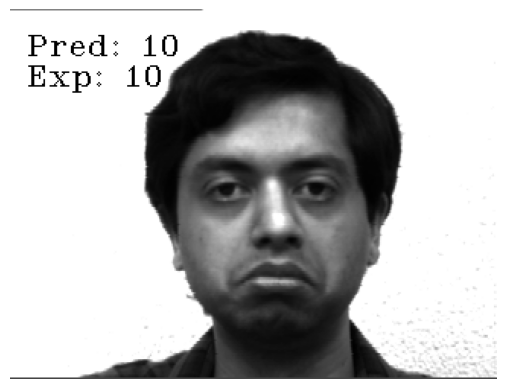

In [25]:
cv2.putText(image_np, 'Pred: ' + str(prediction[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
cv2.putText(image_np, 'Exp: ' + str(expected_output), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
show_image(image_np)

## Evaluating the face classifier

In [31]:
paths = [os.path.join('/content/yalefaces/test', f) for f in os.listdir('/content/yalefaces/test')]
predictions = []
expected_outputs = []
for path in paths:
  #print(path)
  image = Image.open(path).convert('L')
  image_np = np.array(image, 'uint8')
  prediction, _ = lbph_face_classifier.predict(image_np)
  expected_output = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

  predictions.append(prediction)
  expected_outputs.append(expected_output)

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(expected_outputs, predictions)

0.6666666666666666

<Axes: >

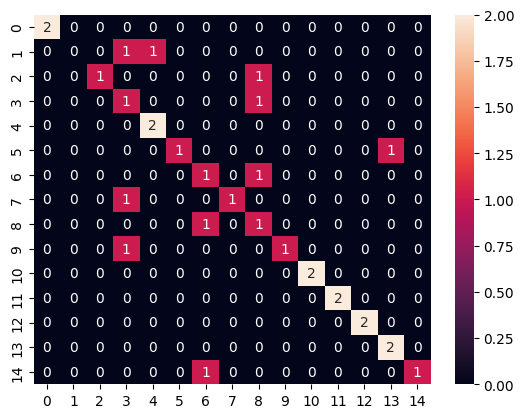

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn
cm = confusion_matrix(expected_outputs, predictions)
seaborn.heatmap(cm, annot=True)

## LBPH parameters

In [35]:
lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius=4, neighbors=14, grid_x=9, grid_y=9)
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

In [38]:
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('lbph_classifier.yml')

In [40]:
paths = [os.path.join('yalefaces/test', f) for f in os.listdir('yalefaces/test')]
predictions = []
expected_outputs = []

for path in paths:
    image = Image.open(path).convert('L')
    image_np = np.array(image, 'uint8')
    prediction, _ = lbph_face_classifier.predict(image_np)
    expected_output = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

    predictions.append(prediction)
    expected_outputs.append(expected_output)
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(expected_outputs, predictions)

0.7

<Axes: >

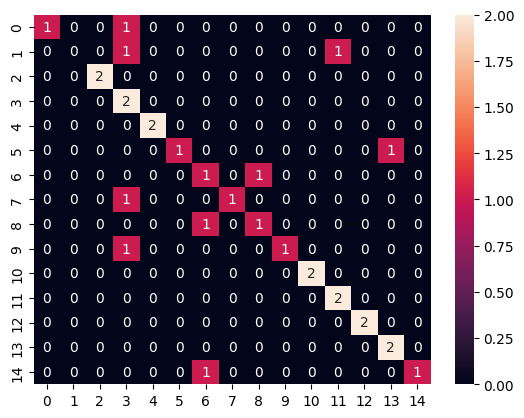

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn
cm = confusion_matrix(expected_outputs, predictions)
seaborn.heatmap(cm, annot=True)

## Detecting facial points

In [44]:
import dlib

In [45]:
'''
We are going to work with a more complex technique and we need to detect facial points and also facil descritors in order to send the image information to the dlib algorithm
'''
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('/content/drive/MyDrive/Programação/ComputerVisionMasterclass/Weights/shape_predictor_68_face_landmarks.dat')
# when we detect a face using this algorithm the algorithm will find 68 points in the face in order to consider it as a face

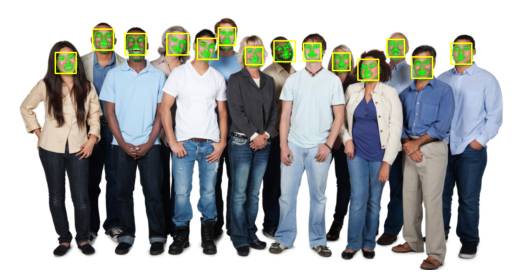

In [46]:
image = cv2.imread('/content/drive/MyDrive/Programação/ComputerVisionMasterclass/Images/people2.jpg')
face_detection = face_detector(image, 1)
for face in face_detection:
    points = points_detector(image, face)
    for point in points.parts():
        cv2.circle(image, (point.x, point.y), 2, (0, 255, 0), 0)


    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image, (l, t), (r, b), (0, 255, 255), 2)
show_image(image)

## Detecting facial descriptors

In [48]:
import os
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('/content/drive/MyDrive/Programação/ComputerVisionMasterclass/Weights/shape_predictor_68_face_landmarks.dat')
face_descriptor_extractor = dlib.face_recognition_model_v1('/content/drive/MyDrive/Programação/ComputerVisionMasterclass/Weights/dlib_face_recognition_resnet_model_v1.dat')

RuntimeError: Error while calling cudaGetDevice(&the_device_id) in file /root/.cache/uv/sdists-v4/pypi/dlib/19.24.2/wJ21y9fWLAAfM7Pm6Ge3a/dlib-19.24.2.tar.gz/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version